In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('./Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Dataset/Users.csv
./Dataset/Ratings.csv
./Dataset/Books.csv


# **LOAD & CHECK DATA**

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

In [3]:
books=pd.read_csv("Dataset/Books.csv")
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [4]:
ratings=pd.read_csv("Dataset/Ratings.csv")
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [5]:
users=pd.read_csv("Dataset/Users.csv")
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [6]:
print("Books Shape: " ,books.shape )
print("Ratings Shape: " ,ratings.shape )
print("Users Shape: " ,users.shape )

Books Shape:  (271360, 8)
Ratings Shape:  (1149780, 3)
Users Shape:  (278858, 3)


In [7]:
print("Any null values in Books:\n" ,books.isnull().sum())
print("Any null values in Ratings:\n ",ratings.isnull().sum())
print("Any null values in Users:\n",users.isnull().sum())

Any null values in Books:
 ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings:
  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users:
 User-ID          0
Location         0
Age         110762
dtype: int64


# **PREPROCESSING**

In [8]:
books_data=books.merge(ratings,on="ISBN")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [9]:
df=books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629,9


# **POPULARITY BASED RECOMMENDATION SYSTEM**

* Popularity based recommendation systems are based on the rating of items by all the users.
* Popularity based recommendation systems works with the trend. It basically uses the items which are in trend right now.

In [10]:
def popular_books(df,n=100):
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    
    popularBooks=rating_count.merge(rating_average,on="Book-Title")
    
    def weighted_rate(x):
        v=x["NumberOfVotes"]
        R=x["AverageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularBooks["AverageRatings"].mean()
    m=popularBooks["NumberOfVotes"].quantile(0.90)
    
    popularBooks=popularBooks[popularBooks["NumberOfVotes"] >=250]
    popularBooks["Popularity"]=popularBooks.apply(weighted_rate,axis=1)
    popularBooks=popularBooks.sort_values(by="Popularity",ascending=False)
    return popularBooks[["Book-Title","NumberOfVotes","AverageRatings","Popularity"]].reset_index(drop=True).head(n)

In [11]:
n=10
top_ten=pd.DataFrame(popular_books(df,10))
display(top_ten)

,Book-Title,NumberOfVotes,AverageRatings,Popularity
0,Harry Potter and the Prisoner of Azkaban Book 3,277,9.043321,9.016348
1,To Kill a Mockingbird,267,8.977528,8.950773
2,Harry Potter and the Sorcerer s Stone Harry Po...,315,8.936508,8.914407
3,Harry Potter and the Chamber of Secrets Book 2,326,8.840491,8.820575
4,Tuesdays with Morrie An Old Man a Young Man an...,250,8.588000,8.567099
5,The Secret Life of Bees,406,8.477833,8.466205
6,The Da Vinci Code,494,8.439271,8.430081
7,The Lovely Bones A Novel,707,8.185290,8.180632
8,The Red Tent Bestselling Backlist,383,8.182768,8.174253
9,Where the Heart Is Oprah s Book Club Paperback,295,8.142373,8.132034


# **USER-BASED COLLABORATIVE FILTERING**

In [12]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 200]  # Drop users who vote less than 200 times.
users_pivot=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_pivot.fillna(0,inplace=True)

In [13]:
def users_choice(id):
    
    users_fav=new_df[new_df["User-ID"]==id].sort_values(["Book-Rating"],ascending=False)[0:5]
    return users_fav

In [14]:
def user_based(new_df,id):
    if id not in new_df["User-ID"].values:
        print("❌ User NOT FOUND ❌")
        
        
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=list(enumerate(similarity[index]))
        similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
    
        user_rec=[]
    
        for i in similar_users:
                data=df[df["User-ID"]==users_pivot.index[i[0]]]
                user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))
        
    return user_rec

In [15]:
def common(new_df,user,user_id):
    x=new_df[new_df["User-ID"]==user_id]
    recommend_books=[]
    user=list(user)
    for i in user:
        y=new_df[(new_df["User-ID"]==i)]
        books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
        books=books.sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(books["Book-Title"].values)
        
    return recommend_books[0:5]

In [16]:
user_id=random.choice(new_df["User-ID"].values)
user_choice_df=pd.DataFrame(users_choice(user_id))
user_favorite=users_choice(user_id)
n=len(user_choice_df["Book-Title"].values)
print("🟦 USER: {} ".format(user_id))
#print(user_choice_df)

user_based_rec=user_based(new_df,user_id)
books_for_user=common(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["Book-Title"])
display(books_for_userDF.head(5))

🟦 USER: 168245 


,Book-Title
0,The Tommyknockers
1,The Promise
2,Tuesdays with Morrie An Old Man a Young Man an...
3,Lightning
4,Good in Bed


# **CONTENT-BASED COLLABORATIVE FILTERING** 

In [17]:
def content_based(bookTitle):
    bookTitle=str(bookTitle)
    
    #print("In 1")
    if bookTitle in df['Book-Title'].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rating_count.reset_index()
        #print(rating_count)
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])] # type: ignore
            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])
            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==bookTitle]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            books=[]
            for i in range(len(similar_booksSorted)):
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())
            #fig,ax=plt.subplots(1,5,figsize=(17,5))
            #fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="chocolate")
            display(books)
    else:
        print("❌ COULD NOT FIND ❌")               

In [18]:
content_based("The Da Vinci Code")

['The Catcher in the Rye',
 'The Brethren',
 'The Firm',
 'The Chamber',
 'The Partner']

In [19]:
content_based("A Soldier of the Great War")

No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
Wild Animus 

Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson 

Harry Potter and the Chamber of Secrets Book 2 



# **EVALUATION METRIC** 

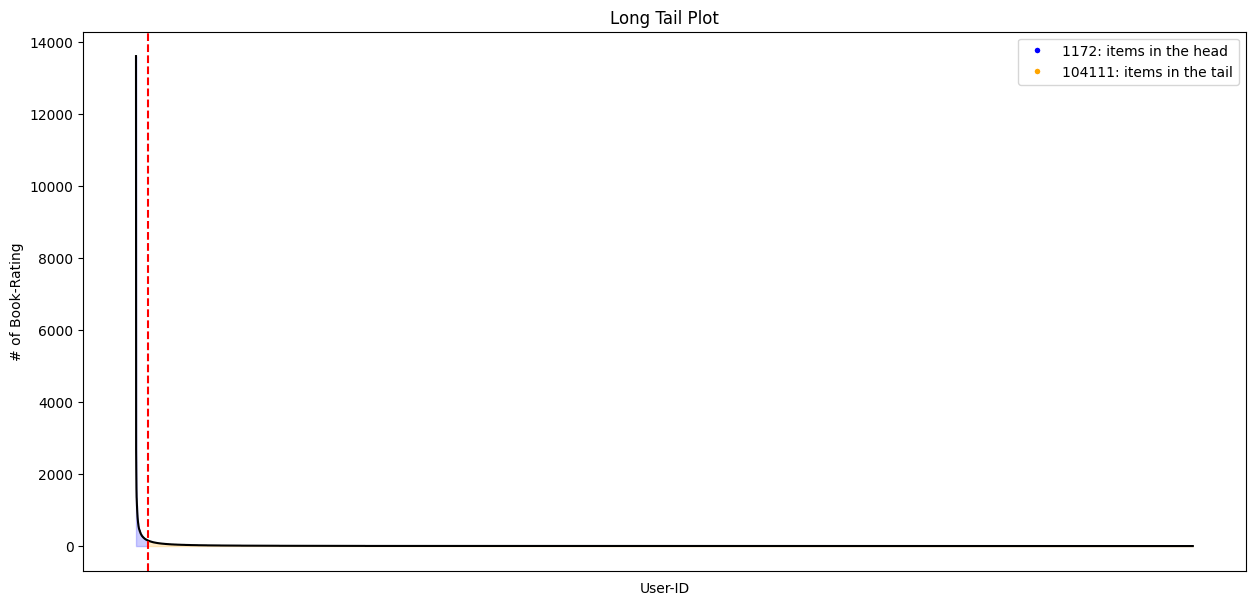

In [20]:
# Long Tail Plot Example
import recmetrics
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="User-ID", 
             interaction_type="Book-Rating", 
             percentage=0.5,
             x_labels=False)

In [21]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
#Format data for Surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
#Train SVD Recommender
algo = SVD()
algo.fit(trainset)
#Make predictions on SVD test set
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'ISBN', 'actual', 'cf_predictions']
test.head()

,userId,ISBN,actual,cf_predictions
0,171778,0440409462,0.0,3.232413
1,113467,0843948507,0.0,2.167310
2,104442,034541005X,0.0,4.393194
3,24733,0345424603,0.0,5.000000
4,163759,0373806817,5.0,4.505475


In [22]:
#Evaluate model with MSE and RMSE
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))


MSE:  12.273111617729947
RMSE:  3.503300103863491


In [23]:
#Popularity Recommender
#Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

#make recommendations for all members in the test data
popularity_recs = ratings.ISBN.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()


,userId,ISBN,actual,cf_predictions,pop_predictions
0,171778,0440409462,0.0,3.232413,"[0971880107, 0316666343, 0385504209, 006092833..."
1,113467,0843948507,0.0,2.167310,"[0971880107, 0316666343, 0385504209, 006092833..."
2,104442,034541005X,0.0,4.393194,"[0971880107, 0316666343, 0385504209, 006092833..."
3,24733,0345424603,0.0,5.000000,"[0971880107, 0316666343, 0385504209, 006092833..."
4,163759,0373806817,5.0,4.505475,"[0971880107, 0316666343, 0385504209, 006092833..."


In [24]:
# make recommendations for all members in the test data
cf_recs = []
for user in new_df["User-ID"].values:
    cf_predictions = user_based(new_df,user)
    cf_recs.append(cf_predictions[0])
        
test['cf_predictions'] = cf_recs
test.head()

KeyboardInterrupt: 

In [68]:
#Prediction Coverage
catalog = ratings.movieId.unique().tolist()
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)
#Catalog Coverage
# N=100 observed recommendation lists
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)
#Coverage Plot
# plot of prediction coverage
coverage_scores = [pop_coverage, cf_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

SyntaxError: invalid syntax (70190712.py, line 1)

In [ ]:
#Novelty
nov = ratings.ISBN.value_counts()
pop = dict(nov)
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)
print(random_novelty, pop_novelty, cf_novelty)